# Author: Mikita Sazanovich

In [2]:
import os
import random
import subprocess
import matplotlib.pyplot as plt
import numpy as np
from numpy import mean
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

from kaldi.feat.mfcc import Mfcc, MfccOptions
from kaldi.matrix import SubVector, SubMatrix
from kaldi.util.options import ParseOptions
from kaldi.util.table import SequentialWaveReader, SequentialMatrixReader, MatrixWriter

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence

from tqdm import tqdm

In [3]:
NUM_PEOPLE = 10

np.random.seed(7)

train_wav_paths = []
train_classes = []
test_wav_paths = []
test_classes = []
wav_dir = os.path.join('VCTK-Corpus', 'wav48')
persons = sorted(os.listdir(wav_dir))[:NUM_PEOPLE]
print(persons)
for num, person in enumerate(persons):
    person_dir = os.path.join(wav_dir, person)
    wav_names = list(map(lambda wav_name: os.path.join(person_dir, wav_name), os.listdir(person_dir)))
    train_person_speech, test_person_speech = train_test_split(wav_names, test_size=0.2)
    train_wav_paths.extend(train_person_speech)
    train_classes.extend([num] * len(train_person_speech))
    test_wav_paths.extend(test_person_speech)
    test_classes.extend([num] * len(test_person_speech))
print('Number of people={}'.format(NUM_PEOPLE))
print('train:', len(train_wav_paths), len(train_classes))
print('test:', len(test_wav_paths), len(test_classes))

['p225', 'p226', 'p227', 'p228', 'p229', 'p230', 'p231', 'p232', 'p233', 'p234']
Number of people=10
train: 2966 2966
test: 749 749


In [4]:
def write_descriptor(wav_paths, desc_path):
    with open(desc_path, 'w') as output:
        for wav_path in wav_paths:
            output.write('{} {}\n'.format(wav_path, wav_path))
            
train_desc_path = 'train_desc.scp'
test_desc_path = 'test_desc.scp'
write_descriptor(train_wav_paths, train_desc_path)
write_descriptor(test_wav_paths, test_desc_path)

In [5]:
def compute_kaldi_features(desc_path, output_path, samp_freq=8000):
    print('Started processing', desc_path)
    rspec, wspec = 'scp:{}'.format(desc_path), 'ark:{}'.format(output_path)
    
    mfcc_opts = MfccOptions()
    mfcc_opts.frame_opts.samp_freq = samp_freq

    mfcc = Mfcc(mfcc_opts)
    sf = mfcc_opts.frame_opts.samp_freq
    
    with SequentialWaveReader(rspec) as reader, MatrixWriter(wspec) as writer: 
        for key, wav in reader:
            assert(wav.samp_freq >= sf)
            assert(wav.samp_freq % sf == 0)

            s = wav.data()
            s = s[:,::int(wav.samp_freq / sf)]
            m = SubVector(mean(s, axis=0))

            f = mfcc.compute_features(m, sf, 1.0)
            f = SubMatrix(scale(f))
            writer[key] = f
    print('Success! Result is written to', output_path)

In [6]:
train_kaldi_path = 'train_kaldi.ark'
test_kaldi_path = 'test_kaldi.ark'
compute_kaldi_features(train_desc_path, train_kaldi_path)
compute_kaldi_features(test_desc_path, test_kaldi_path)

Started processing train_desc.scp
Success! Result is written to train_kaldi.ark
Started processing test_desc.scp
Success! Result is written to test_kaldi.ark


In [21]:
def read_features(kaldi_path):
    features = []
    rspec = 'ark:{}'.format(kaldi_path)
    with SequentialMatrixReader(rspec) as reader:
        for key, mat in reader:
            features.append(torch.tensor(mat, dtype=torch.float))
    return features

train_features = read_features(train_kaldi_path)
test_features = read_features(test_kaldi_path)

In [22]:
print('Train:', len(train_features), len(train_classes))
print('Test:', len(test_features), len(test_classes))

Train: 2966 2966
Test: 749 749


In [23]:
class SpeakerIdentityLSTM(nn.Module):
    
    def __init__(self, feature_dim, hidden_dim, num_classes):
        super(SpeakerIdentityLSTM, self).__init__()
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(feature_dim, hidden_dim, num_layers=1)
        
        self.hidden2class = nn.Linear(hidden_dim, num_classes)
        self.hidden = None
        self.softmax = nn.LogSoftmax(dim=1)
        
    def __init_hidden(self, batch_size):
        # The axes semantics are (num_layers, batch_size, hidden_dim)
        return (torch.zeros(1, batch_size, self.hidden_dim).cuda(),
                torch.zeros(1, batch_size, self.hidden_dim).cuda())
    
    def __get_class_scores(self, batch, lengths):
        self.hidden = self.__init_hidden(batch.size(0))
        packed_input = pack_padded_sequence(batch, lengths, batch_first=True)
        outputs, (ht, ct) = self.lstm(packed_input, self.hidden)
        class_scores = self.hidden2class(ht[-1])
        
        return class_scores
    
    def forward(self, batch, lengths):
        class_scores = self.__get_class_scores(batch, lengths)
        output = self.softmax(class_scores)
        
        return output
    
    def predict_classes(self, batch, lengths):
        class_scores = self.__get_class_scores(batch, lengths)
        classes = class_scores.argmax(dim=1)
        
        return classes

In [24]:
current_device = torch.cuda.current_device()
print(torch.cuda.get_device_name(current_device))

GeForce GTX 1080 Ti


In [39]:
def pack_feature_class_lists(features, classes, ids):
    ids = sorted(ids, key=lambda ind: features[ind].size(0), reverse=True)
    lengths = list(map(lambda ind: features[ind].size(0), ids))
    seq = list(map(lambda ind: features[ind], ids))
    inputs = pad_sequence(seq, batch_first=True).cuda()
    targets = torch.tensor(list(map(lambda ind: classes[ind], ids)), dtype=torch.long)
    return inputs, lengths, targets

def train_lstm(train_features, train_classes, test_features, test_classes):
    EPOCHS = 1000
    BATCH_SIZE = 1024
    HIDDEN_DIM = 64

    torch.manual_seed(7)
    np.random.seed(7)

    model = SpeakerIdentityLSTM(train_features[0].shape[1], HIDDEN_DIM, NUM_PEOPLE).cuda()
    criterion = nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=1e-2)

    N_train = len(train_features)
    N_test = len(test_features)
    train_ids = list(range(N_train))
    test_ids = list(range(N_test))

    train_losses = []
    test_accuracies = []

    for epoch in tqdm(range(EPOCHS)):
        np.random.shuffle(train_ids)
    
        model.train()
        train_loss = 0
        for i in range(0, N_train, BATCH_SIZE):
            model.zero_grad()
            train_inputs, train_lens, train_targets = pack_feature_class_lists(
                train_features, train_classes, train_ids[i:i+BATCH_SIZE])
            class_log_probs = model(train_inputs, train_lens).cpu()
            loss = criterion(class_log_probs, train_targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss)

        model.eval()
        correct = 0
        for i in range(0, N_test, BATCH_SIZE):
            test_inputs, test_lens, test_targets = pack_feature_class_lists(
                test_features, test_classes,test_ids[i:i+BATCH_SIZE])
            test_predictions = model.predict_classes(test_inputs, test_lens).cpu()
            correct += (test_predictions == test_targets).sum().item()
        accuracy = 100 * correct / N_test
        test_accuracies.append(accuracy)
    return train_losses, test_accuracies

In [40]:
train_kaldi_losses, test_kaldi_accuracies = train_lstm(
    train_features, train_classes, test_features, test_classes)

100%|██████████| 1000/1000 [03:59<00:00,  4.06it/s]


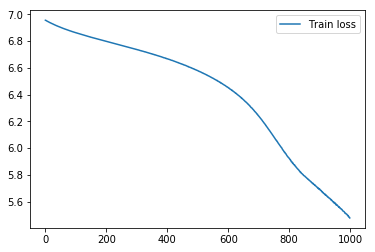

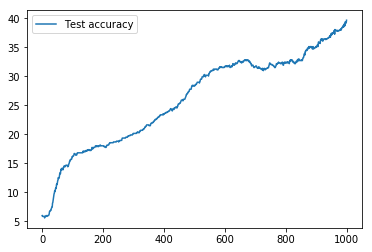

In [43]:
plt.plot(range(len(train_kaldi_losses)), train_kaldi_losses)
plt.legend(['Train loss'])
plt.show()

plt.plot(range(len(test_kaldi_accuracies)), test_kaldi_accuracies)
plt.legend(['Test accuracy'])
plt.show()

In [44]:
noised_wav_dir = os.path.join('VCTK-Corpus', 'noised')
assert os.path.exists(noised_wav_dir)
train_noised_paths = []
for train_wav_path in train_wav_paths:
    head, filename = os.path.split(train_wav_path)
    _, dirname = os.path.split(head)
    train_noised_path = os.path.join(noised_wav_dir, dirname, filename)
    assert os.path.exists(train_noised_path)
    train_noised_paths.append(train_noised_path)
train_noised_desc_path = 'train_noised_desc.scp'
write_descriptor(train_noised_paths, train_noised_desc_path)

In [45]:
train_kaldi_noised_path = 'train_kaldi_noised.ark'
compute_kaldi_features(train_noised_desc_path, train_kaldi_noised_path)
train_noised_features = read_features(train_kaldi_noised_path)

Started processing train_noised_desc.scp
Success! Result is written to train_kaldi_noised.ark


In [52]:
AUTO_HID = 13

class Autoencoder(nn.Module):

    def __init__(self):
        super(Autoencoder, self).__init__()
        self._encoder = nn.Sequential(
            nn.Linear(13, 64),
            nn.ReLU(True),
            nn.Linear(64, AUTO_HID),
            nn.ReLU(True))
        self._decoder = nn.Sequential(
            nn.Linear(AUTO_HID, 64),
            nn.ReLU(True),
            nn.Linear(64, 13))

    def encode(self, x):
        return self._encoder(x)

    def decode(self, x):
        return self._decoder(x)

    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

In [56]:
def train_autoencoder(noised_features, features):
    AUTO_EPOCHS = 20
    BATCH_SIZE = 32768
    
    torch.manual_seed(7)
    np.random.seed(7)

    autoencoder = Autoencoder().cuda()
    criterion = nn.MSELoss()
    optimizer = optim.SGD(autoencoder.parameters(), lr=1e-2)

    xs = []
    ys = []
    for noised_feature, feature in zip(noised_features, features):
        for i in range(noised_feature.shape[0]):
            xs.append(noised_feature[i].numpy())
            ys.append(feature[i].numpy())

    N_train = len(xs)
    print('Total pairs for denoising:', N_train)
    train_ids = list(range(N_train))

    auto_train_losses = []

    for epoch in tqdm(range(AUTO_EPOCHS)):
        np.random.shuffle(train_ids)

        autoencoder.train()
        train_loss = 0
        for i in range(0, N_train, BATCH_SIZE):
            ids = train_ids[i:i+BATCH_SIZE]
            seq = list(map(lambda ind: xs[ind], ids))
            X_batch = torch.tensor(seq, dtype=torch.float).cuda()
            Y_pred = autoencoder(X_batch).cpu()
            seq = list(map(lambda ind: ys[ind], ids))
            Y_batch = torch.tensor(seq, dtype=torch.float)
            loss = criterion(Y_pred, Y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        auto_train_losses.append(train_loss)
    autoencoder.eval()
    return autoencoder.cpu(), auto_train_losses

In [57]:
autoencoder, autoencoder_losses = train_autoencoder(train_features, train_noised_features)


  0%|          | 0/100 [00:00<?, ?it/s]

Total pairs for denoising: 1054069



100%|██████████| 100/100 [08:00<00:00,  5.00s/it]

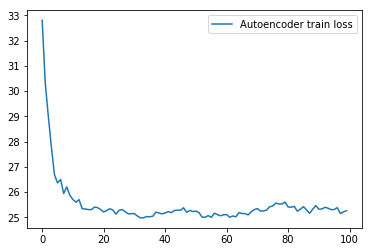

In [58]:
plt.plot(range(len(autoencoder_losses)), autoencoder_losses)
plt.legend(['Autoencoder train loss'])
plt.show()

In [64]:
def compute_auto_features(features_all):
    auto_features_all = []
    for features in features_all:
        K = features.shape[0]
        auto_features = []
        for k in range(K):
            auto_features.append(autoencoder.encode(features[k]).detach())
        auto_features_all.append(torch.stack(auto_features))
    return auto_features_all

train_auto_features = compute_auto_features(train_features)
test_auto_features = compute_auto_features(test_features)

In [65]:
train_auto_losses, test_auto_accuracies = train_lstm(
    train_auto_features, train_classes, test_auto_features, test_classes)




  0%|          | 0/1000 [00:00<?, ?it/s]


  0%|          | 1/1000 [00:00<04:15,  3.90it/s]


  0%|          | 2/1000 [00:00<04:15,  3.91it/s]


  0%|          | 3/1000 [00:00<04:13,  3.94it/s]


  0%|          | 4/1000 [00:01<04:14,  3.92it/s]


  0%|          | 5/1000 [00:01<04:14,  3.91it/s]


  1%|          | 6/1000 [00:01<04:13,  3.93it/s]


  1%|          | 7/1000 [00:01<04:11,  3.94it/s]


  1%|          | 8/1000 [00:02<04:12,  3.92it/s]


  1%|          | 9/1000 [00:02<04:11,  3.93it/s]


  1%|          | 10/1000 [00:02<04:11,  3.93it/s]


  1%|          | 11/1000 [00:02<04:11,  3.94it/s]


  1%|          | 12/1000 [00:03<04:12,  3.91it/s]


  1%|▏         | 13/1000 [00:03<04:11,  3.93it/s]


  1%|▏         | 14/1000 [00:03<04:09,  3.95it/s]


  2%|▏         | 15/1000 [00:03<04:06,  4.00it/s]


  2%|▏         | 16/1000 [00:04<04:02,  4.05it/s]


  2%|▏         | 17/1000 [00:04<04:09,  3.94it/s]


  2%|▏         | 18/1000 [00:04<04:12,  3.90it/s]


  2%|▏         | 19/1000 [0

 13%|█▎        | 134/1000 [00:33<03:34,  4.04it/s]


 14%|█▎        | 135/1000 [00:33<03:33,  4.05it/s]


 14%|█▎        | 136/1000 [00:34<03:31,  4.09it/s]


 14%|█▎        | 137/1000 [00:34<03:31,  4.08it/s]


 14%|█▍        | 138/1000 [00:34<03:33,  4.04it/s]


 14%|█▍        | 139/1000 [00:34<03:34,  4.02it/s]


 14%|█▍        | 140/1000 [00:35<03:35,  4.00it/s]


 14%|█▍        | 141/1000 [00:35<03:32,  4.04it/s]


 14%|█▍        | 142/1000 [00:35<03:30,  4.08it/s]


 14%|█▍        | 143/1000 [00:35<03:28,  4.12it/s]


 14%|█▍        | 144/1000 [00:36<03:26,  4.14it/s]


 14%|█▍        | 145/1000 [00:36<03:27,  4.13it/s]


 15%|█▍        | 146/1000 [00:36<03:26,  4.14it/s]


 15%|█▍        | 147/1000 [00:36<03:26,  4.13it/s]


 15%|█▍        | 148/1000 [00:36<03:27,  4.11it/s]


 15%|█▍        | 149/1000 [00:37<03:25,  4.15it/s]


 15%|█▌        | 150/1000 [00:37<03:25,  4.13it/s]


 15%|█▌        | 151/1000 [00:37<03:22,  4.19it/s]


 15%|█▌        | 152/1000 [00:37<03:24,  4.15i

 27%|██▋       | 266/1000 [01:05<02:57,  4.15it/s]


 27%|██▋       | 267/1000 [01:05<02:58,  4.11it/s]


 27%|██▋       | 268/1000 [01:05<02:55,  4.16it/s]


 27%|██▋       | 269/1000 [01:06<02:58,  4.10it/s]


 27%|██▋       | 270/1000 [01:06<03:00,  4.04it/s]


 27%|██▋       | 271/1000 [01:06<02:59,  4.07it/s]


 27%|██▋       | 272/1000 [01:06<02:58,  4.08it/s]


 27%|██▋       | 273/1000 [01:07<02:56,  4.11it/s]


 27%|██▋       | 274/1000 [01:07<02:57,  4.09it/s]


 28%|██▊       | 275/1000 [01:07<02:58,  4.06it/s]


 28%|██▊       | 276/1000 [01:07<02:56,  4.10it/s]


 28%|██▊       | 277/1000 [01:08<02:55,  4.12it/s]


 28%|██▊       | 278/1000 [01:08<02:56,  4.09it/s]


 28%|██▊       | 279/1000 [01:08<02:56,  4.09it/s]


 28%|██▊       | 280/1000 [01:08<02:52,  4.16it/s]


 28%|██▊       | 281/1000 [01:09<02:52,  4.16it/s]


 28%|██▊       | 282/1000 [01:09<02:51,  4.18it/s]


 28%|██▊       | 283/1000 [01:09<02:51,  4.18it/s]


 28%|██▊       | 284/1000 [01:09<02:51,  4.18i

 40%|███▉      | 398/1000 [01:37<02:29,  4.04it/s]


 40%|███▉      | 399/1000 [01:37<02:29,  4.01it/s]


 40%|████      | 400/1000 [01:38<02:30,  4.00it/s]


 40%|████      | 401/1000 [01:38<02:30,  3.98it/s]


 40%|████      | 402/1000 [01:38<02:30,  3.98it/s]


 40%|████      | 403/1000 [01:38<02:31,  3.95it/s]


 40%|████      | 404/1000 [01:39<02:31,  3.93it/s]


 40%|████      | 405/1000 [01:39<02:31,  3.93it/s]


 41%|████      | 406/1000 [01:39<02:29,  3.96it/s]


 41%|████      | 407/1000 [01:39<02:28,  3.98it/s]


 41%|████      | 408/1000 [01:40<02:28,  3.98it/s]


 41%|████      | 409/1000 [01:40<02:27,  4.00it/s]


 41%|████      | 410/1000 [01:40<02:28,  3.97it/s]


 41%|████      | 411/1000 [01:40<02:28,  3.95it/s]


 41%|████      | 412/1000 [01:41<02:27,  4.00it/s]


 41%|████▏     | 413/1000 [01:41<02:24,  4.08it/s]


 41%|████▏     | 414/1000 [01:41<02:23,  4.09it/s]


 42%|████▏     | 415/1000 [01:41<02:23,  4.09it/s]


 42%|████▏     | 416/1000 [01:42<02:21,  4.13i

 53%|█████▎    | 530/1000 [02:09<01:55,  4.08it/s]


 53%|█████▎    | 531/1000 [02:09<01:54,  4.09it/s]


 53%|█████▎    | 532/1000 [02:09<01:53,  4.11it/s]


 53%|█████▎    | 533/1000 [02:10<01:53,  4.11it/s]


 53%|█████▎    | 534/1000 [02:10<01:52,  4.13it/s]


 54%|█████▎    | 535/1000 [02:10<01:52,  4.12it/s]


 54%|█████▎    | 536/1000 [02:10<01:51,  4.17it/s]


 54%|█████▎    | 537/1000 [02:11<01:51,  4.16it/s]


 54%|█████▍    | 538/1000 [02:11<01:50,  4.18it/s]


 54%|█████▍    | 539/1000 [02:11<01:51,  4.12it/s]


 54%|█████▍    | 540/1000 [02:11<01:51,  4.13it/s]


 54%|█████▍    | 541/1000 [02:12<01:49,  4.19it/s]


 54%|█████▍    | 542/1000 [02:12<01:50,  4.15it/s]


 54%|█████▍    | 543/1000 [02:12<01:50,  4.13it/s]


 54%|█████▍    | 544/1000 [02:12<01:49,  4.16it/s]


 55%|█████▍    | 545/1000 [02:13<01:49,  4.17it/s]


 55%|█████▍    | 546/1000 [02:13<01:48,  4.17it/s]


 55%|█████▍    | 547/1000 [02:13<01:48,  4.17it/s]


 55%|█████▍    | 548/1000 [02:13<01:47,  4.20i

 66%|██████▌   | 662/1000 [02:41<01:26,  3.90it/s]


 66%|██████▋   | 663/1000 [02:42<01:26,  3.91it/s]


 66%|██████▋   | 664/1000 [02:42<01:25,  3.91it/s]


 66%|██████▋   | 665/1000 [02:42<01:25,  3.90it/s]


 67%|██████▋   | 666/1000 [02:42<01:25,  3.91it/s]


 67%|██████▋   | 667/1000 [02:43<01:25,  3.91it/s]


 67%|██████▋   | 668/1000 [02:43<01:25,  3.90it/s]


 67%|██████▋   | 669/1000 [02:43<01:24,  3.90it/s]


 67%|██████▋   | 670/1000 [02:43<01:24,  3.91it/s]


 67%|██████▋   | 671/1000 [02:44<01:23,  3.93it/s]


 67%|██████▋   | 672/1000 [02:44<01:23,  3.92it/s]


 67%|██████▋   | 673/1000 [02:44<01:22,  3.95it/s]


 67%|██████▋   | 674/1000 [02:44<01:22,  3.93it/s]


 68%|██████▊   | 675/1000 [02:45<01:21,  3.99it/s]


 68%|██████▊   | 676/1000 [02:45<01:20,  4.02it/s]


 68%|██████▊   | 677/1000 [02:45<01:19,  4.08it/s]


 68%|██████▊   | 678/1000 [02:45<01:18,  4.10it/s]


 68%|██████▊   | 679/1000 [02:46<01:18,  4.08it/s]


 68%|██████▊   | 680/1000 [02:46<01:18,  4.06i

 79%|███████▉  | 794/1000 [03:13<00:49,  4.14it/s]


 80%|███████▉  | 795/1000 [03:14<00:48,  4.19it/s]


 80%|███████▉  | 796/1000 [03:14<00:48,  4.20it/s]


 80%|███████▉  | 797/1000 [03:14<00:48,  4.21it/s]


 80%|███████▉  | 798/1000 [03:14<00:48,  4.17it/s]


 80%|███████▉  | 799/1000 [03:15<00:48,  4.14it/s]


 80%|████████  | 800/1000 [03:15<00:47,  4.17it/s]


 80%|████████  | 801/1000 [03:15<00:47,  4.17it/s]


 80%|████████  | 802/1000 [03:15<00:47,  4.15it/s]


 80%|████████  | 803/1000 [03:15<00:46,  4.19it/s]


 80%|████████  | 804/1000 [03:16<00:46,  4.20it/s]


 80%|████████  | 805/1000 [03:16<00:46,  4.22it/s]


 81%|████████  | 806/1000 [03:16<00:46,  4.20it/s]


 81%|████████  | 807/1000 [03:16<00:45,  4.23it/s]


 81%|████████  | 808/1000 [03:17<00:45,  4.23it/s]


 81%|████████  | 809/1000 [03:17<00:45,  4.22it/s]


 81%|████████  | 810/1000 [03:17<00:45,  4.22it/s]


 81%|████████  | 811/1000 [03:17<00:44,  4.22it/s]


 81%|████████  | 812/1000 [03:18<00:44,  4.21i

 93%|█████████▎| 926/1000 [03:46<00:18,  4.05it/s]


 93%|█████████▎| 927/1000 [03:46<00:17,  4.08it/s]


 93%|█████████▎| 928/1000 [03:46<00:17,  4.12it/s]


 93%|█████████▎| 929/1000 [03:46<00:17,  4.10it/s]


 93%|█████████▎| 930/1000 [03:46<00:16,  4.14it/s]


 93%|█████████▎| 931/1000 [03:47<00:16,  4.21it/s]


 93%|█████████▎| 932/1000 [03:47<00:16,  4.21it/s]


 93%|█████████▎| 933/1000 [03:47<00:15,  4.25it/s]


 93%|█████████▎| 934/1000 [03:47<00:15,  4.23it/s]


 94%|█████████▎| 935/1000 [03:48<00:15,  4.21it/s]


 94%|█████████▎| 936/1000 [03:48<00:15,  4.21it/s]


 94%|█████████▎| 937/1000 [03:48<00:14,  4.22it/s]


 94%|█████████▍| 938/1000 [03:48<00:14,  4.18it/s]


 94%|█████████▍| 939/1000 [03:49<00:14,  4.15it/s]


 94%|█████████▍| 940/1000 [03:49<00:14,  4.13it/s]


 94%|█████████▍| 941/1000 [03:49<00:14,  4.13it/s]


 94%|█████████▍| 942/1000 [03:49<00:14,  4.10it/s]


 94%|█████████▍| 943/1000 [03:50<00:13,  4.10it/s]


 94%|█████████▍| 944/1000 [03:50<00:13,  4.04i

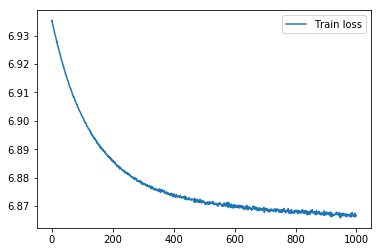

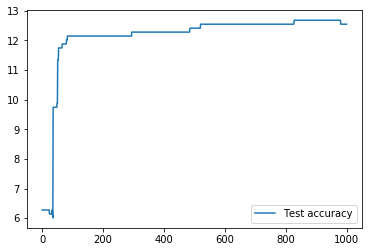

In [66]:
plt.plot(range(len(train_auto_losses)), train_auto_losses)
plt.legend(['Train loss'])
plt.show()

plt.plot(range(len(test_auto_accuracies)), test_auto_accuracies)
plt.legend(['Test accuracy'])
plt.show()

In [70]:
def build_merged_features(features1_all, features2_all):
    merged_features_all = []
    for features1, features2 in zip(features1_all, features2_all):
        merged_features = torch.cat((features1, features2), dim=1)
        merged_features_all.append(merged_features)
    return merged_features_all

train_merged_features = build_merged_features(train_features, train_auto_features)
test_merged_features = build_merged_features(test_features, test_auto_features)

In [71]:
train_merged_losses, test_merged_accuracies = train_lstm(
    train_merged_features, train_classes, test_merged_features, test_classes)




  0%|          | 0/1000 [00:00<?, ?it/s]


  0%|          | 1/1000 [00:00<05:36,  2.97it/s]


  0%|          | 2/1000 [00:00<05:34,  2.98it/s]


  0%|          | 3/1000 [00:00<05:31,  3.01it/s]


  0%|          | 4/1000 [00:01<05:32,  2.99it/s]


  0%|          | 5/1000 [00:01<05:31,  3.00it/s]


  1%|          | 6/1000 [00:01<05:29,  3.02it/s]


  1%|          | 7/1000 [00:02<05:22,  3.08it/s]


  1%|          | 8/1000 [00:02<05:24,  3.06it/s]


  1%|          | 9/1000 [00:02<05:26,  3.04it/s]


  1%|          | 10/1000 [00:03<05:22,  3.07it/s]


  1%|          | 11/1000 [00:03<05:29,  3.00it/s]


  1%|          | 12/1000 [00:03<05:35,  2.95it/s]


  1%|▏         | 13/1000 [00:04<05:39,  2.90it/s]


  1%|▏         | 14/1000 [00:04<05:37,  2.92it/s]


  2%|▏         | 15/1000 [00:05<05:40,  2.89it/s]


  2%|▏         | 16/1000 [00:05<05:37,  2.91it/s]


  2%|▏         | 17/1000 [00:05<05:38,  2.90it/s]


  2%|▏         | 18/1000 [00:06<05:35,  2.93it/s]


  2%|▏         | 19/1000 [0

 13%|█▎        | 134/1000 [00:43<04:29,  3.22it/s]


 14%|█▎        | 135/1000 [00:43<04:30,  3.19it/s]


 14%|█▎        | 136/1000 [00:44<04:30,  3.19it/s]


 14%|█▎        | 137/1000 [00:44<04:31,  3.18it/s]


 14%|█▍        | 138/1000 [00:44<04:30,  3.19it/s]


 14%|█▍        | 139/1000 [00:45<04:28,  3.21it/s]


 14%|█▍        | 140/1000 [00:45<04:28,  3.20it/s]


 14%|█▍        | 141/1000 [00:45<04:27,  3.22it/s]


 14%|█▍        | 142/1000 [00:46<04:26,  3.21it/s]


 14%|█▍        | 143/1000 [00:46<04:25,  3.23it/s]


 14%|█▍        | 144/1000 [00:46<04:26,  3.21it/s]


 14%|█▍        | 145/1000 [00:46<04:27,  3.20it/s]


 15%|█▍        | 146/1000 [00:47<04:27,  3.20it/s]


 15%|█▍        | 147/1000 [00:47<04:27,  3.19it/s]


 15%|█▍        | 148/1000 [00:47<04:31,  3.13it/s]


 15%|█▍        | 149/1000 [00:48<04:32,  3.12it/s]


 15%|█▌        | 150/1000 [00:48<04:35,  3.09it/s]


 15%|█▌        | 151/1000 [00:48<04:29,  3.15it/s]


 15%|█▌        | 152/1000 [00:49<04:28,  3.16i

 27%|██▋       | 266/1000 [01:24<03:49,  3.20it/s]


 27%|██▋       | 267/1000 [01:25<03:49,  3.20it/s]


 27%|██▋       | 268/1000 [01:25<03:47,  3.21it/s]


 27%|██▋       | 269/1000 [01:25<03:49,  3.19it/s]


 27%|██▋       | 270/1000 [01:26<03:48,  3.19it/s]


 27%|██▋       | 271/1000 [01:26<03:49,  3.18it/s]


 27%|██▋       | 272/1000 [01:26<03:50,  3.16it/s]


 27%|██▋       | 273/1000 [01:27<03:48,  3.19it/s]


 27%|██▋       | 274/1000 [01:27<03:46,  3.21it/s]


 28%|██▊       | 275/1000 [01:27<03:47,  3.19it/s]


 28%|██▊       | 276/1000 [01:28<03:48,  3.17it/s]


 28%|██▊       | 277/1000 [01:28<03:51,  3.13it/s]


 28%|██▊       | 278/1000 [01:28<03:52,  3.11it/s]


 28%|██▊       | 279/1000 [01:29<03:58,  3.02it/s]


 28%|██▊       | 280/1000 [01:29<03:55,  3.06it/s]


 28%|██▊       | 281/1000 [01:29<03:53,  3.08it/s]


 28%|██▊       | 282/1000 [01:29<03:51,  3.11it/s]


 28%|██▊       | 283/1000 [01:30<03:49,  3.12it/s]


 28%|██▊       | 284/1000 [01:30<03:49,  3.12i

 40%|███▉      | 398/1000 [02:07<03:21,  2.99it/s]


 40%|███▉      | 399/1000 [02:07<03:22,  2.97it/s]


 40%|████      | 400/1000 [02:07<03:22,  2.97it/s]


 40%|████      | 401/1000 [02:08<03:19,  3.01it/s]


 40%|████      | 402/1000 [02:08<03:15,  3.06it/s]


 40%|████      | 403/1000 [02:08<03:13,  3.08it/s]


 40%|████      | 404/1000 [02:09<03:12,  3.09it/s]


 40%|████      | 405/1000 [02:09<03:11,  3.10it/s]


 41%|████      | 406/1000 [02:09<03:08,  3.15it/s]


 41%|████      | 407/1000 [02:10<03:06,  3.18it/s]


 41%|████      | 408/1000 [02:10<03:05,  3.19it/s]


 41%|████      | 409/1000 [02:10<03:04,  3.21it/s]


 41%|████      | 410/1000 [02:11<03:04,  3.20it/s]


 41%|████      | 411/1000 [02:11<03:05,  3.17it/s]


 41%|████      | 412/1000 [02:11<03:07,  3.14it/s]


 41%|████▏     | 413/1000 [02:12<03:09,  3.10it/s]


 41%|████▏     | 414/1000 [02:12<03:07,  3.12it/s]


 42%|████▏     | 415/1000 [02:12<03:07,  3.13it/s]


 42%|████▏     | 416/1000 [02:13<03:05,  3.15i

 53%|█████▎    | 530/1000 [02:49<02:31,  3.11it/s]


 53%|█████▎    | 531/1000 [02:49<02:30,  3.12it/s]


 53%|█████▎    | 532/1000 [02:50<02:30,  3.10it/s]


 53%|█████▎    | 533/1000 [02:50<02:29,  3.11it/s]


 53%|█████▎    | 534/1000 [02:50<02:28,  3.13it/s]


 54%|█████▎    | 535/1000 [02:51<02:28,  3.13it/s]


 54%|█████▎    | 536/1000 [02:51<02:28,  3.13it/s]


 54%|█████▎    | 537/1000 [02:51<02:32,  3.04it/s]


 54%|█████▍    | 538/1000 [02:52<02:30,  3.07it/s]


 54%|█████▍    | 539/1000 [02:52<02:30,  3.06it/s]


 54%|█████▍    | 540/1000 [02:52<02:28,  3.10it/s]


 54%|█████▍    | 541/1000 [02:52<02:25,  3.16it/s]


 54%|█████▍    | 542/1000 [02:53<02:25,  3.14it/s]


 54%|█████▍    | 543/1000 [02:53<02:25,  3.13it/s]


 54%|█████▍    | 544/1000 [02:53<02:25,  3.14it/s]


 55%|█████▍    | 545/1000 [02:54<02:25,  3.13it/s]


 55%|█████▍    | 546/1000 [02:54<02:25,  3.11it/s]


 55%|█████▍    | 547/1000 [02:54<02:25,  3.12it/s]


 55%|█████▍    | 548/1000 [02:55<02:23,  3.14i

 66%|██████▌   | 662/1000 [03:31<01:46,  3.16it/s]


 66%|██████▋   | 663/1000 [03:31<01:46,  3.16it/s]


 66%|██████▋   | 664/1000 [03:32<01:46,  3.15it/s]


 66%|██████▋   | 665/1000 [03:32<01:46,  3.14it/s]


 67%|██████▋   | 666/1000 [03:32<01:45,  3.15it/s]


 67%|██████▋   | 667/1000 [03:33<01:45,  3.15it/s]


 67%|██████▋   | 668/1000 [03:33<01:45,  3.14it/s]


 67%|██████▋   | 669/1000 [03:33<01:45,  3.14it/s]


 67%|██████▋   | 670/1000 [03:34<01:44,  3.15it/s]


 67%|██████▋   | 671/1000 [03:34<01:43,  3.17it/s]


 67%|██████▋   | 672/1000 [03:34<01:43,  3.16it/s]


 67%|██████▋   | 673/1000 [03:35<01:42,  3.18it/s]


 67%|██████▋   | 674/1000 [03:35<01:42,  3.17it/s]


 68%|██████▊   | 675/1000 [03:35<01:42,  3.16it/s]


 68%|██████▊   | 676/1000 [03:36<01:42,  3.16it/s]


 68%|██████▊   | 677/1000 [03:36<01:41,  3.17it/s]


 68%|██████▊   | 678/1000 [03:36<01:42,  3.13it/s]


 68%|██████▊   | 679/1000 [03:37<01:43,  3.10it/s]


 68%|██████▊   | 680/1000 [03:37<01:44,  3.06i

 79%|███████▉  | 794/1000 [04:13<01:06,  3.11it/s]


 80%|███████▉  | 795/1000 [04:14<01:04,  3.17it/s]


 80%|███████▉  | 796/1000 [04:14<01:04,  3.18it/s]


 80%|███████▉  | 797/1000 [04:14<01:03,  3.19it/s]


 80%|███████▉  | 798/1000 [04:15<01:03,  3.17it/s]


 80%|███████▉  | 799/1000 [04:15<01:03,  3.15it/s]


 80%|████████  | 800/1000 [04:15<01:03,  3.15it/s]


 80%|████████  | 801/1000 [04:16<01:03,  3.15it/s]


 80%|████████  | 802/1000 [04:16<01:03,  3.13it/s]


 80%|████████  | 803/1000 [04:16<01:02,  3.15it/s]


 80%|████████  | 804/1000 [04:16<01:02,  3.13it/s]


 80%|████████  | 805/1000 [04:17<01:01,  3.17it/s]


 81%|████████  | 806/1000 [04:17<01:02,  3.13it/s]


 81%|████████  | 807/1000 [04:17<01:02,  3.10it/s]


 81%|████████  | 808/1000 [04:18<01:03,  3.04it/s]


 81%|████████  | 809/1000 [04:18<01:02,  3.04it/s]


 81%|████████  | 810/1000 [04:18<01:02,  3.06it/s]


 81%|████████  | 811/1000 [04:19<01:00,  3.12it/s]


 81%|████████  | 812/1000 [04:19<00:59,  3.14i

 93%|█████████▎| 926/1000 [04:55<00:23,  3.18it/s]


 93%|█████████▎| 927/1000 [04:56<00:22,  3.19it/s]


 93%|█████████▎| 928/1000 [04:56<00:22,  3.15it/s]


 93%|█████████▎| 929/1000 [04:56<00:22,  3.12it/s]


 93%|█████████▎| 930/1000 [04:57<00:22,  3.11it/s]


 93%|█████████▎| 931/1000 [04:57<00:22,  3.13it/s]


 93%|█████████▎| 932/1000 [04:57<00:21,  3.11it/s]


 93%|█████████▎| 933/1000 [04:58<00:21,  3.13it/s]


 93%|█████████▎| 934/1000 [04:58<00:21,  3.10it/s]


 94%|█████████▎| 935/1000 [04:58<00:21,  3.09it/s]


 94%|█████████▎| 936/1000 [04:59<00:20,  3.09it/s]


 94%|█████████▎| 937/1000 [04:59<00:20,  3.10it/s]


 94%|█████████▍| 938/1000 [04:59<00:20,  3.07it/s]


 94%|█████████▍| 939/1000 [05:00<00:19,  3.05it/s]


 94%|█████████▍| 940/1000 [05:00<00:19,  3.06it/s]


 94%|█████████▍| 941/1000 [05:00<00:19,  3.09it/s]


 94%|█████████▍| 942/1000 [05:01<00:18,  3.11it/s]


 94%|█████████▍| 943/1000 [05:01<00:18,  3.15it/s]


 94%|█████████▍| 944/1000 [05:01<00:17,  3.15i

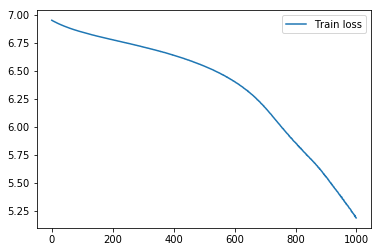

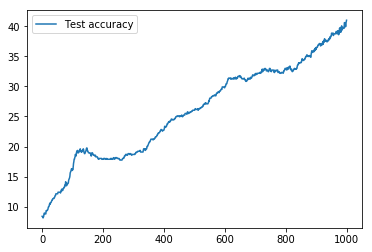

In [72]:
plt.plot(range(len(train_merged_losses)), train_merged_losses)
plt.legend(['Train loss'])
plt.show()

plt.plot(range(len(test_merged_accuracies)), test_merged_accuracies)
plt.legend(['Test accuracy'])
plt.show()

# Ablation study results

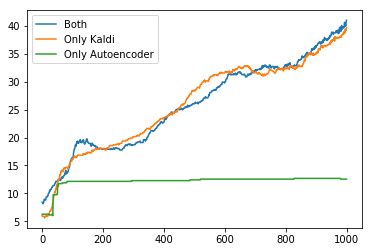

In [74]:
plt.plot(range(len(test_merged_accuracies)), test_merged_accuracies)
plt.plot(range(len(test_kaldi_accuracies)), test_kaldi_accuracies)
plt.plot(range(len(test_auto_accuracies)), test_auto_accuracies)
plt.legend(['Both', 'Only Kaldi', 'Only Autoencoder'])
plt.show()